In [1]:
import time
import math
import copy
import torch
import pickle
import random
import logging
import warnings
import datetime
import pandas as pd
import numpy as np
from copy import deepcopy
import torch.nn as nn
import torch.optim as opt
from torch.autograd import grad, Variable
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from imblearn.under_sampling import RandomUnderSampler
import fairlearn.datasets
from tqdm import tqdm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from torch.autograd import grad
from torch.autograd.functional import vhp
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, log_loss, r2_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, classification_report
from scipy.stats import spearmanr
from folktables import ACSDataSource, ACSIncome, ACSPublicCoverage

import scienceplots
warnings.filterwarnings("ignore")

E = math.e

In [2]:
ds = ACSDataSource(survey_year='2018', horizon='5-Year', survey='person')
STATE_DATA = ds.get_data(states=["AR"], download=True)

### Utility Functions

In [3]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm
import scienceplots

In [4]:
def visualize_result(e_k_actual, e_k_estimated, ep, k_):
    plt.rcParams['figure.dpi'] = 300
    plt.style.use(['science'])
#     plt.rcParams.update({'font.size': 5})
    colors = cm.cool(np.linspace(0, 1, len(e_k_estimated)))
#     e_k_estimated = [-1*ek for ek in e_k_estimated]
    fig, ax = plt.subplots()
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    
    min_x = np.min(e_k_actual)
    max_x = np.max(e_k_actual)
    min_y = np.min(e_k_estimated)
    max_y = np.max(e_k_estimated)
    
# #     plt.rcParams['figure.figsize'] = 15, 15
    z = np.polyfit(e_k_actual,  e_k_estimated, 1)
    p = np.poly1d(z)
    xx = np.linspace(-p(2)/p(1), max(e_k_actual)+.0001)
    yy = np.polyval(p, xx)
    #add trendline to plot
    ax.plot(xx, yy, ls="-", color='k')
    
    for k in range(len(e_k_actual)):
        ax.scatter(e_k_actual[k], e_k_estimated[k], zorder=2, s=15, color=colors[k])

    ax.set_title(f'Actual vs. Estimated loss for k={k_:.2f}%', fontsize=8)
    ax.set_xlabel('Actual loss difference', fontsize=8)
    ax.set_ylabel('Estimated loss difference', fontsize=8)
   
    ax.set_xlim(min_x-.0001, max_x+.0001)
    ax.set_ylim(min_y-.0001, max_y+.0001)
    
#     #label_locations = np.arange(5)  
#     #width = 0.25 
    
#     xlabels = np.linspace(min_x-.0001, max_x+.0001, 6)
#     ylabels = np.linspace(min_y-.0001, max_y+.0001, 6)
    
    text = 'MAE = {:.03}\nP = {:.03}'.format(mean_absolute_error(e_k_actual, e_k_estimated), spearmanr(e_k_actual, e_k_estimated).correlation)
#     ax.text(max_x+.00001,min_y-.00008, text, verticalalignment='bottom', horizontalalignment='right', fontsize=8)
# #     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# #     plt.tight_layout()
    print(text)
    plt.xticks(rotation = 45, fontsize=7, visible=True)
    plt.yticks(fontsize=7)
 
    plt.show()
    # cooler color = smaller epsilon

In [5]:
def get_acspubcov(data):
    features, labels, _ = ACSPublicCoverage.df_to_pandas(data)
    
    df = pd.concat([features, labels], axis=1)
    
    df = df.drop_duplicates(keep='first', ignore_index=True)
    df = df.drop(['ANC', 'ST', 'SCHL', 'ESP', 'FER', 'MIG', 'DEAR', 'DEYE', 'DREM'], axis=1)
    
    column_names = ['AGEP', 'MAR', 'SEX', 'DIS', 'CIT', 'PINCP', 'ESR', 'RAC1P', 'MIL', 'NATIVITY']
    
    def numericalBinary(dataset, features):
        dataset[features] = np.where(dataset[features] >= dataset[features].mean(), 1, 0)

    def binarize(dataset, features):
        dataset[features] = np.where(df[features] == 1, 1, 0)
            
    numericalBinary(df,['AGEP', 'PINCP'])
    binarize(df, ['MAR', 'SEX', 'DIS', 'RAC1P', 'PUBCOV', 'NATIVITY'])
    
    #df['ESP'] = np.where((df['ESP'] == 1) | (df['ESP'] == 2) | (df['ESP'] == 3) | (df['ESP'] == 4), 1, 0)
    df['CIT'] = np.where((df['CIT'] == 1) | (df['CIT'] == 3), 1, 0)
    df['MIL'] = np.where((df['MIL'] == 1) | (df['MIL'] == 2) | (df['MIL'] == 3), 1, 0)
    df['ESR'] = np.where((df['ESR'] == 1) | (df['ESR'] == 2) | (df['ESR'] == 4) | (df['ESR'] == 5), 1, 0)
    
#     to_replace = ['workclass', 'education-num', 'marital-status', 'occupation','relationship', 'native-country']
#     dfTrain = pd.get_dummies(dfTrain, columns=to_replace, drop_first = False)
    
    num_train = int(len(df) * .8)
    dfTrain = df.sample(n=num_train, replace=False, axis=0, ignore_index=False)

    dfTest = df.drop(dfTrain.index, axis=0)
    
    label = 'PUBCOV'
    return dfTrain, dfTest, label

In [6]:
 class CreateData(torch.utils.data.Dataset):
    def __init__(self, data, targets, pert_status):
        self.data = data
        self.targets = targets
        self.pert = pert_status

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.targets[idx]
        pert_label = self.pert[idx]

        return out_data, out_label, pert_label

In [7]:
def get_data(dfTrain, feature_set, label, k):    

    selected_group = dfTrain.loc[dfTrain['SEX'] == 0]

    num_to_sample = int((k/100)*len(dfTrain))

    sampled_group = selected_group.sample(n=num_to_sample, ignore_index=False)
    not_selected = dfTrain.drop(sampled_group.index)

    selected_group_X = sampled_group[feature_set]
    selected_group_y = sampled_group[label]

    not_selected_group_X = not_selected[feature_set]
    not_selected_group_y = not_selected[label]   
    
    return selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y


### Randomized Response

In [8]:
def get_p(epsilon):
    prob_stay = (E ** epsilon) / (1 + (E ** epsilon))
    prob_change = 1 / (1 + (E ** epsilon))
    
    p = torch.zeros(2,2)
    for i in range(2):
        for j in range(2):
            if i == j: 
                p[i][j] = prob_stay
            else:
                p[i][j] = prob_change
    
    return p

In [9]:
def forward_correct_loss(y_act, oupt, epsilon, criterion, device):
    
    p = get_p(epsilon)
    y_pred_c = torch.matmul(oupt, p.to(device)) 
    loss = criterion(torch.log(y_pred_c), y_act.ravel())
    
    return loss 

### Models

In [10]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        
        self.fc1 = torch.nn.Linear(num_features, 2)
        self.criterion = torch.nn.NLLLoss(reduction='mean')
        self.activ = torch.nn.Softmax()
        
    def forward(self, x):
        probs = self.activ(self.fc1(x))

        return probs
    
    def loss(self, test_loader, print_, device):
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_loss = 0
        
        for features, labels, _ in test_loader:
            features = Variable(features).to(device)
            labels = Variable(labels).to(device)
            outputs = self.fc1(features)
            loss = self.criterion(outputs, labels)
            all_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total+= labels.size(0)
            
            all_labels.extend(list(labels.detach().cpu().numpy()))
            all_predicted.extend(list(predicted.detach().cpu().numpy()))
            correct+= (predicted.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()
        acc = 100 * correct/total
        
        return loss/len(test_loader), acc

In [11]:
def train(model, dataset, epsilon, lengths, device):
    model.train()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=.005, weight_decay=0)
    criterion = torch.nn.NLLLoss(reduction='mean')
    pert_status = np.zeros(len(dataset[0]))
 
    if lengths is not None:
        len_original = lengths[0]
        len_perts = lengths[1]
        total_len = len(dataset[0])
        pert_status = []
        pert_status.extend(np.zeros(len_original))
        pert_status.extend(np.ones(len_perts))
    
    train_data = CreateData(dataset[0], dataset[1], pert_status)
    train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
        
    for itr in range(0, 7):
        itr_loss = 0
        correct = 0
        total = 0
        
        for i, (features, labels, pert_val) in enumerate(train_dataloader):
            features = Variable(features).to(device)
            labels = Variable(labels).to(device)
           
            optimizer.zero_grad()
            outputs = model(features)
            
            if pert_val == 0:
                loss_val = criterion(torch.log(outputs), labels.ravel())
            else:
                loss_val = forward_correct_loss(labels, outputs, epsilon, torch.nn.NLLLoss(reduction='sum'), device)

            itr_loss += loss_val
            loss_val.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total+= labels.size(0)
            correct+= (predicted.detach().cpu() == labels.detach().cpu()).sum()
                        
    return model

### Influence Calculation Functions


In [12]:
def calc_influence_single(model, epsilon, train_dataset, train_dataloader, test_dataloader, group_data, device, criterion, hessian):
    start = time.time()
    
    if hessian is None:
        s_test_vec = s_test_sample(model, test_dataloader, train_dataset, device, criterion)
    else:
        s_test_vec = hessian
   
    grad_z_vec = grad_training([group_data[0], group_data[1]], model, device, epsilon)
    
    with torch.no_grad():
        influence = (sum([torch.sum(k * j).data for k, j in zip(grad_z_vec, s_test_vec)]) / len(train_dataset))
            
    end = time.time() - start

    return influence.cpu(), end, s_test_vec

In [13]:
def s_test_sample(model, test_dataloader, train_dataset, device, criterion):
    scale = 25
    damp = 0.01
    recursion_depth = 7500
    r = 3
    
    inverse_hvp = [torch.zeros_like(params, dtype=torch.float) for params in model.parameters()]
    
    for i in range(r):
        hessian_loader = DataLoader(train_dataset, sampler=torch.utils.data.RandomSampler(train_dataset, True, num_samples=recursion_depth), batch_size = 1)
        
        cur_estimate = s_test(test_dataloader, model, i, hessian_loader, device, damp, scale, criterion)
        
        with torch.no_grad():
            inverse_hvp = [old + (cur/scale) for old,cur in zip(inverse_hvp, cur_estimate)]
    
    with torch.no_grad():
        inverse_hvp = [component / r for component in inverse_hvp]
        
    return inverse_hvp

In [14]:
def s_test(test_dataloader, model, i, hessian_loader, device, damp, scale, criterion):
    v = grad_z(test_dataloader, model, device, criterion)
    h_estimate = v
    
    params, names = make_functional(model)
    params = tuple(p.detach().requires_grad_() for p in params)
    
    progress_bar = tqdm(hessian_loader, desc=f"IHVP sample {i}")
    
    for i, (x_train, y_train, _) in enumerate(progress_bar):
        x_train = Variable(x_train).to(device)
        y_train = Variable(y_train).to(device)
        
        def f(*new_params):
            load_weights(model, names, new_params)
            out = model(x_train)
            loss = criterion(out, y_train)
            return loss
    
        hv = vhp(f, params, tuple(h_estimate), strict=True)[1]
        
        with torch.no_grad():
            h_estimate = [
                _v + (1-damp) * _h_e - _hv / scale for _v, _h_e, _hv in zip(v, h_estimate, hv)
            ]
            
            if i % 100 == 0:
                norm = sum([h_.norm() for h_ in h_estimate])
                progress_bar.set_postfix({"est norm": norm.item()})
                
    with torch.no_grad():
        load_weights(model, names, params, as_params=True)
        
    return h_estimate

In [15]:
def make_functional(model):
    orig_params = tuple(model.parameters())
    names = []
    
    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)
    
    return orig_params, names

In [16]:
def del_attr(obj, names):
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        del_attr(getattr(obj, names[0]), names[1:])

In [17]:
def set_attr(obj, names, val):
    if len(names) == 1:
        setattr(obj, names[0], val)
    else:
        set_attr(getattr(obj, names[0]), names[1:], val)

In [18]:
def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        if not as_params:
            set_attr(model, name.split("."), p)
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

In [19]:
def grad_z(test_data, model, device, criterion):

    model.eval()

    itr_loss = 0
    for i, (images, labels, _) in enumerate(test_data):
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        itr_loss += loss

    loss_ = itr_loss / len(test_data)
    return grad(loss_, model.parameters())

In [20]:
def grad_training(train_data, model, device, epsilon):

    model.eval()

    x_train_input = torch.FloatTensor(train_data[0].values).to(device)
    y_train_input = torch.LongTensor(train_data[1].values).to(device)
    pert_status = np.ones(len(train_data[0]))
    
    train_data = CreateData(x_train_input, y_train_input, pert_status)
    train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)

    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    
    agg_loss=0
    possible_labels = [0,1]
    for i, (feature, label, _) in enumerate(train_dataloader):
        pert_agg_loss = 0
        
        output = model(feature)
        orig_loss = criterion(output, label)

        for j in possible_labels:
            if j != label.item():
                pert_label = torch.LongTensor([j]).to(device)
                pert_loss = forward_correct_loss(pert_label, output, epsilon, criterion, device)
                pert_agg_loss += (pert_loss - orig_loss)
                
        agg_loss += pert_agg_loss
        
    loss = float(1/(1 + (E ** epsilon)))*(agg_loss)
    
    to_return = grad(loss, model.parameters())
        
    return to_return

### Main Function

In [21]:
def Main(dataset, epsilons, ks, num_rounds):

    device = 'cuda:6' if torch.cuda.is_available() else 'cpu'
    criterion = torch.nn.NLLLoss(reduction='mean')
    
    all_orig_loss_e_k = []
    all_est_loss_e_k = []
    all_time = []
    
    for nr in range(num_rounds):
        print(f'\nRound {nr+1}')
        ############
        # Get data #
        ############
        print('\nGetting Data...')

        dfTrain, dfTest, label = get_acspubcov(STATE_DATA)

        feature_set = list(set(dfTrain.columns) - {label})
        num_features = len(feature_set)

        X_train, X_test = dfTrain[feature_set], dfTest[feature_set]
        y_train, y_test = dfTrain[label], dfTest[label]
        
        
        x_test_input = torch.FloatTensor(X_test.values).to(device)
        y_test_input = torch.LongTensor(y_test.values).to(device)
        pert_status_test = np.ones(len(x_test_input))
        
        x_train_input = torch.FloatTensor(X_train.values).to(device)
        y_train_input = torch.LongTensor(y_train.values).to(device)
        pert_status_train = np.ones(len(x_train_input))
    
        train_dataset = CreateData(x_train_input, y_train_input, pert_status_train)
        test_dataset = CreateData(x_test_input, y_test_input, pert_status_test)

    
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
   
        ##############################################
        # Train original model and get original loss #
        ##############################################
        print('Training original model...')
        torch_model = LogisticRegression(num_features)
#         torch.save(torch_model.state_dict(), 'initial_config.pth')
        torch_model.to(device)
        torch_model = train(torch_model, [x_train_input, y_train_input], None, None, device)
        test_loss_ori, acc_ori = torch_model.loss(test_loader, True, device)

        e_k_act_losses = []
        e_k_est_losses = []
        influence_time = []
        
        ################################################################
        # Perform influence and retraining for all epsilons a k values #
        ################################################################
        print('\nBegining epsilon and k rounds')
        print('-----------------------------')
        for k_elem, k in enumerate(ks):
            print(f'\nk: {k}')
            hessian = None
            k_act_losses = []
            k_est_losses = []
            inf_time = []
            
            for ep_elem, ep in enumerate(epsilons):
                # Influence
                print(f'ep: {ep}')
                selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y = get_data(dfTrain, feature_set, label, k)
                loss_diff_approx, tot_time, hessian = calc_influence_single(torch_model, ep, train_dataset, train_loader, test_loader, [selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y], device, criterion, hessian)
                loss_diff_approx = -torch.FloatTensor(loss_diff_approx).cpu().numpy()
                print(f'Approx difference: {loss_diff_approx:.5f}')
                
                # Retrain - need to actually perturb
                p = ((E**ep)/(1+(E**ep)))
                p_change = (1/(1+(E**ep)))

                pert_selected_group_y = []
                
                for i, elem in enumerate(selected_group_y.values):
                    rnd = np.random.random()
                    if rnd <= p:
                        pert_selected_group_y.append(elem)
                    else:
                        pert_selected_group_y.append(1 - elem)
                    
                y_w_group_pert = pd.concat([not_selected_group_y, pd.DataFrame(pert_selected_group_y)], axis = 0, ignore_index=True ) 
                y_wo_pert = pd.concat([not_selected_group_y, selected_group_y], axis = 0, ignore_index=True)
                reconstructed_x = pd.concat([not_selected_group_X, selected_group_X], axis = 0, ignore_index=True)
                                           
                x_train_input_pert = torch.FloatTensor(reconstructed_x.values).to(device)
                y_train_input_pert = torch.LongTensor(y_w_group_pert.values).to(device)

                model_pert = LogisticRegression(num_features)
#                 model_pert.load_state_dict(torch.load('initial_config.pth'))
                model_pert.to(device)
                model_pert = train(model_pert, [x_train_input_pert, y_train_input_pert], ep, [len(not_selected_group_y), len(selected_group_y)], device)
                test_loss_retrain, acc_retrain = model_pert.loss(test_loader, True, device)

                 # get true loss diff
                loss_diff_true = (test_loss_retrain - test_loss_ori).detach().cpu().item()
                print(f'True difference: {loss_diff_true:.5f}')
                k_act_losses.append(loss_diff_true)
                k_est_losses.append(loss_diff_approx)
                inf_time.append(tot_time)
            
            visualize_result(k_act_losses, k_est_losses, epsilons, k)
            e_k_act_losses.append(k_act_losses)
            e_k_est_losses.append(k_est_losses)
            influence_time.append(inf_time)
            
        all_orig_loss_e_k.append(e_k_act_losses)
        all_est_loss_e_k.append(e_k_est_losses) 
        all_time.append(influence_time)
    
    return all_orig_loss_e_k, all_est_loss_e_k, all_time

### Perform Experiment 

#### Constants

In [22]:
epsilons = np.linspace(.001, 5, 30) #30 5
k = np.linspace(1, 30, 10) #10
rounds = 1


Round 1

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

k: 1.0
ep: 0.001


IHVP sample 2: 100%|███████████████████████████████████████████████| 7500/7500 [00:07<00:00, 1008.24it/s, est norm=5.99]


Approx difference: 0.00004
True difference: 0.00119
ep: 0.17337931034482756
Approx difference: 0.00004
True difference: 0.00043
ep: 0.3457586206896551
Approx difference: 0.00006
True difference: 0.00020
ep: 0.5181379310344827
Approx difference: 0.00005
True difference: 0.00114
ep: 0.6905172413793103
Approx difference: 0.00006
True difference: 0.00193
ep: 0.8628965517241378
Approx difference: 0.00006
True difference: 0.00223
ep: 1.0352758620689653
Approx difference: 0.00008
True difference: -0.00124
ep: 1.207655172413793
Approx difference: 0.00008
True difference: 0.00008
ep: 1.3800344827586204
Approx difference: 0.00009
True difference: -0.00015
ep: 1.5524137931034478
Approx difference: 0.00007
True difference: 0.00102
ep: 1.7247931034482755
Approx difference: 0.00007
True difference: 0.00080
ep: 1.8971724137931032
Approx difference: 0.00008
True difference: 0.00043
ep: 2.0695517241379306
Approx difference: 0.00008
True difference: 0.00144
ep: 2.241931034482758
Approx difference: 0.000

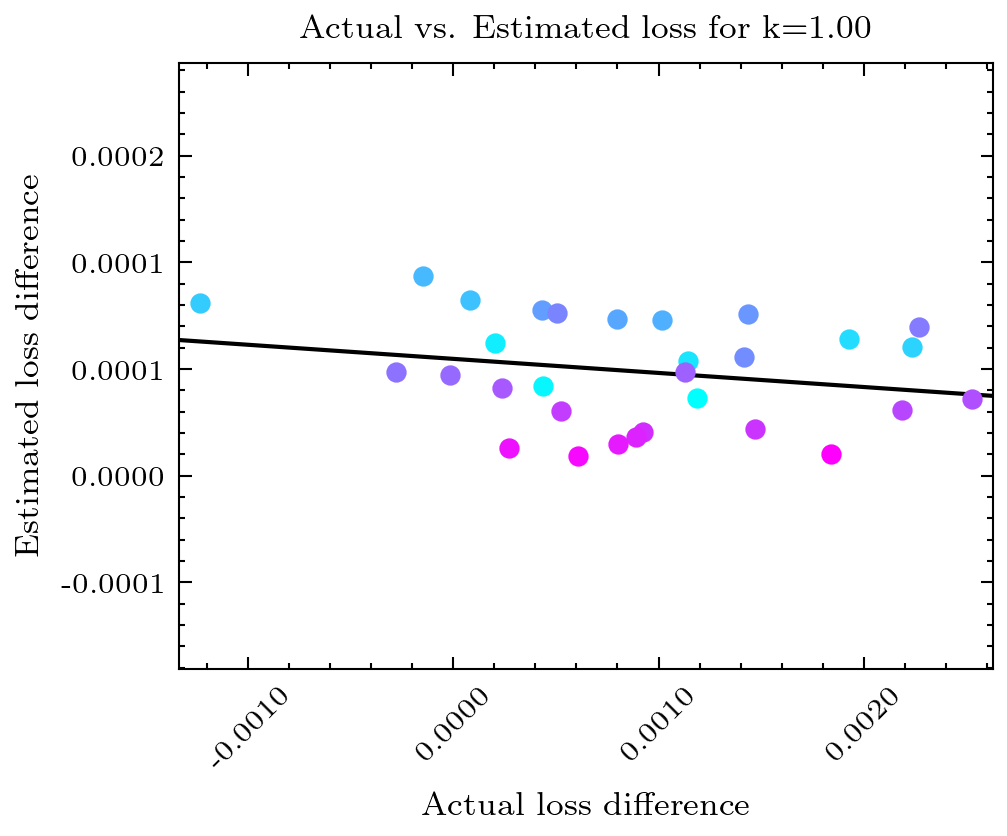


k: 4.222222222222222
ep: 0.001


IHVP sample 2: 100%|███████████████████████████████████████████████| 7500/7500 [00:07<00:00, 1000.77it/s, est norm=6.04]


Approx difference: 0.00013
True difference: 0.00130
ep: 0.17337931034482756
Approx difference: 0.00015
True difference: 0.00074
ep: 0.3457586206896551
Approx difference: 0.00018
True difference: 0.00100
ep: 0.5181379310344827
Approx difference: 0.00026
True difference: 0.00168
ep: 0.6905172413793103
Approx difference: 0.00032
True difference: -0.00040
ep: 0.8628965517241378
Approx difference: 0.00037
True difference: 0.00127
ep: 1.0352758620689653
Approx difference: 0.00039
True difference: 0.00100
ep: 1.207655172413793
Approx difference: 0.00039
True difference: 0.00188
ep: 1.3800344827586204
Approx difference: 0.00044
True difference: -0.00082
ep: 1.5524137931034478
Approx difference: 0.00042
True difference: 0.00078
ep: 1.7247931034482755
Approx difference: 0.00041
True difference: 0.00189
ep: 1.8971724137931032
Approx difference: 0.00040
True difference: 0.00106
ep: 2.0695517241379306
Approx difference: 0.00040
True difference: 0.00095
ep: 2.241931034482758
Approx difference: 0.000

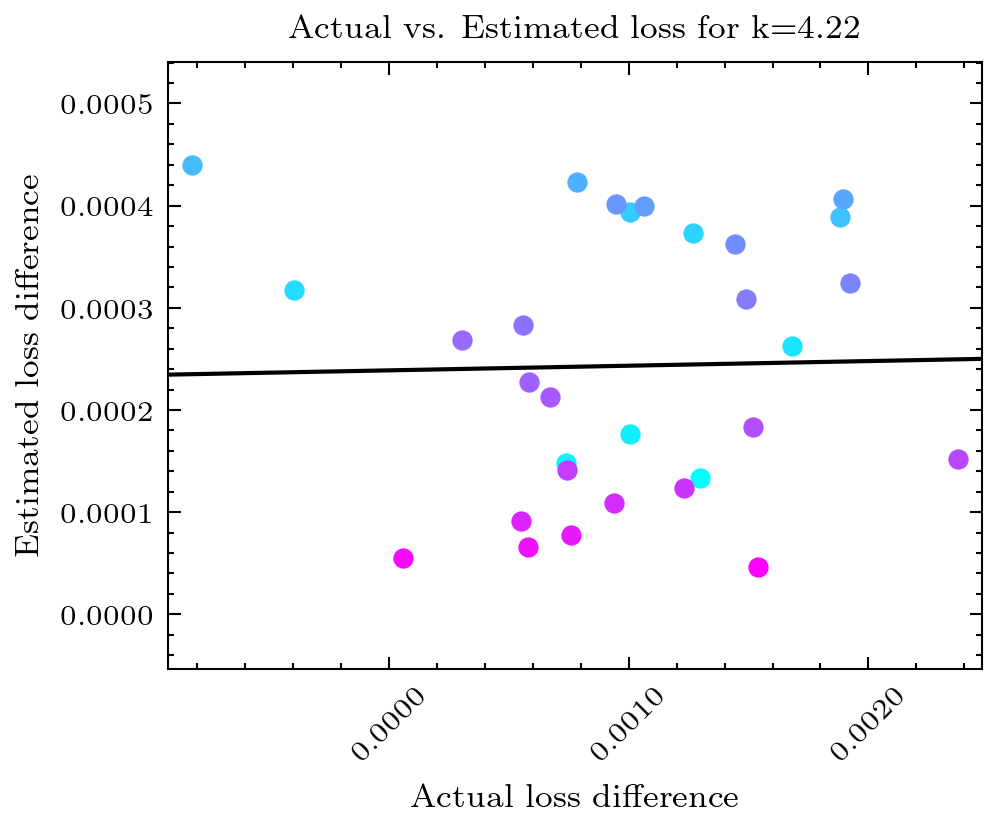


k: 7.444444444444445
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:10<00:00, 721.72it/s, est norm=5.67]


Approx difference: 0.00016
True difference: 0.00085
ep: 0.17337931034482756
Approx difference: 0.00029
True difference: 0.00126
ep: 0.3457586206896551
Approx difference: 0.00027
True difference: 0.00106
ep: 0.5181379310344827
Approx difference: 0.00038
True difference: 0.00008
ep: 0.6905172413793103
Approx difference: 0.00051
True difference: 0.00139
ep: 0.8628965517241378
Approx difference: 0.00054
True difference: 0.00212
ep: 1.0352758620689653
Approx difference: 0.00060
True difference: -0.00091
ep: 1.207655172413793
Approx difference: 0.00061
True difference: -0.00054
ep: 1.3800344827586204
Approx difference: 0.00067
True difference: -0.00081
ep: 1.5524137931034478
Approx difference: 0.00068
True difference: 0.00083
ep: 1.7247931034482755
Approx difference: 0.00065
True difference: -0.00022
ep: 1.8971724137931032
Approx difference: 0.00062
True difference: -0.00143
ep: 2.0695517241379306
Approx difference: 0.00057
True difference: 0.00097
ep: 2.241931034482758
Approx difference: 0.

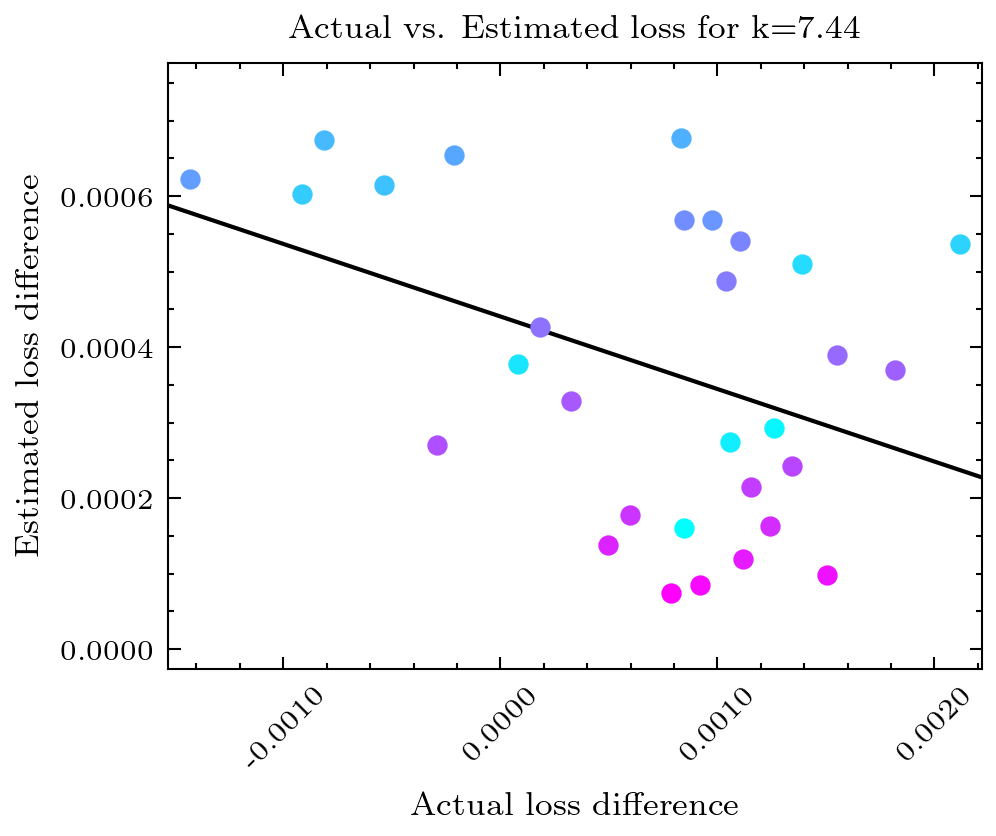


k: 10.666666666666668
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:10<00:00, 721.17it/s, est norm=6.52]


Approx difference: 0.00026
True difference: 0.00120
ep: 0.17337931034482756
Approx difference: 0.00040
True difference: 0.00126
ep: 0.3457586206896551
Approx difference: 0.00053
True difference: 0.00157
ep: 0.5181379310344827
Approx difference: 0.00058
True difference: 0.00266
ep: 0.6905172413793103
Approx difference: 0.00069
True difference: 0.00034
ep: 0.8628965517241378
Approx difference: 0.00082
True difference: 0.00099
ep: 1.0352758620689653
Approx difference: 0.00093
True difference: 0.00101
ep: 1.207655172413793
Approx difference: 0.00092
True difference: 0.00078
ep: 1.3800344827586204
Approx difference: 0.00095
True difference: 0.00028
ep: 1.5524137931034478
Approx difference: 0.00093
True difference: 0.00323
ep: 1.7247931034482755
Approx difference: 0.00095
True difference: 0.00051
ep: 1.8971724137931032
Approx difference: 0.00091
True difference: 0.00051
ep: 2.0695517241379306
Approx difference: 0.00082
True difference: 0.00131
ep: 2.241931034482758
Approx difference: 0.00077

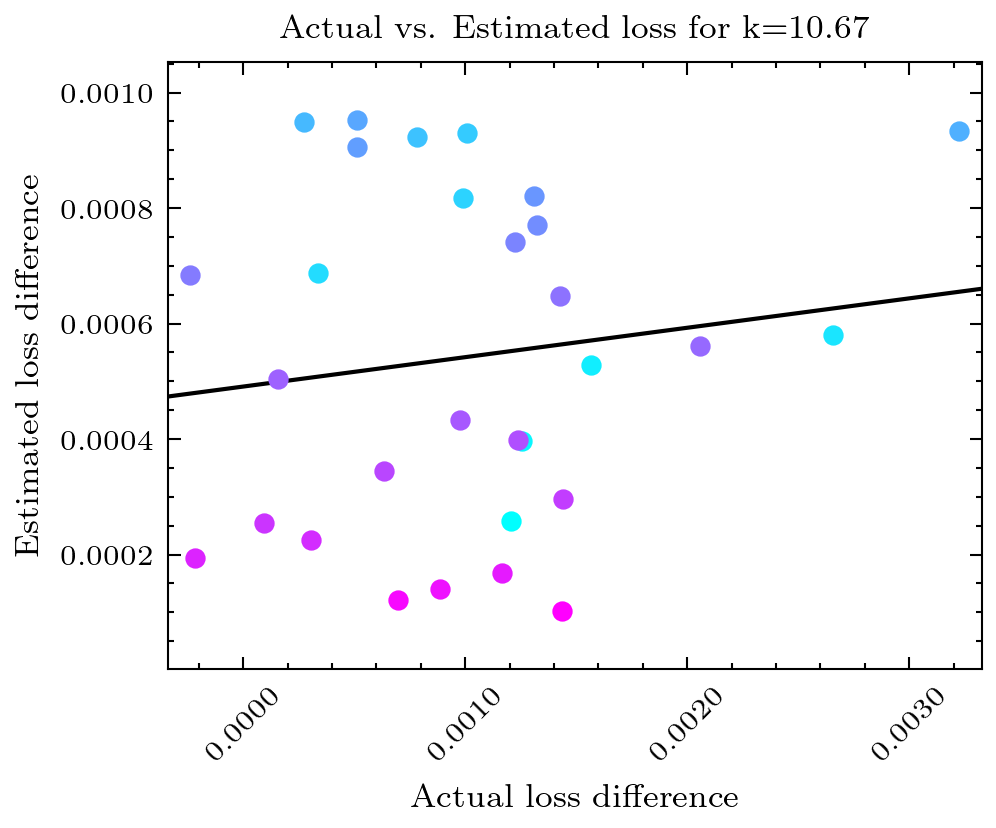


k: 13.88888888888889
ep: 0.001


IHVP sample 2: 100%|█████████████████████████████████████████████████| 7500/7500 [00:08<00:00, 890.99it/s, est norm=5.7]


Approx difference: 0.00029
True difference: -0.00002
ep: 0.17337931034482756
Approx difference: 0.00046
True difference: 0.00021
ep: 0.3457586206896551
Approx difference: 0.00062
True difference: 0.00070
ep: 0.5181379310344827
Approx difference: 0.00079
True difference: -0.00024
ep: 0.6905172413793103
Approx difference: 0.00093
True difference: 0.00069
ep: 0.8628965517241378
Approx difference: 0.00101
True difference: 0.00247
ep: 1.0352758620689653
Approx difference: 0.00109
True difference: 0.00010
ep: 1.207655172413793
Approx difference: 0.00110
True difference: 0.00056
ep: 1.3800344827586204
Approx difference: 0.00108
True difference: 0.00127
ep: 1.5524137931034478
Approx difference: 0.00120
True difference: 0.00011
ep: 1.7247931034482755
Approx difference: 0.00121
True difference: 0.00111
ep: 1.8971724137931032
Approx difference: 0.00110
True difference: 0.00132
ep: 2.0695517241379306
Approx difference: 0.00108
True difference: 0.00099
ep: 2.241931034482758
Approx difference: 0.001

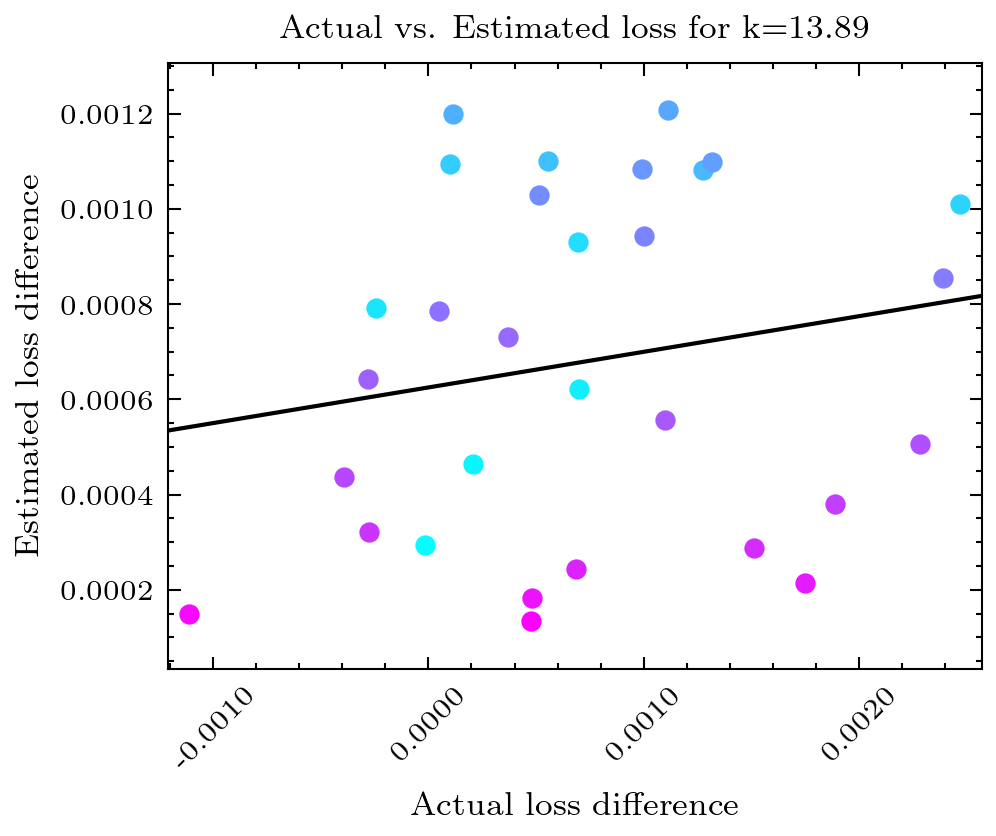


k: 17.11111111111111
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:10<00:00, 707.93it/s, est norm=6.37]


Approx difference: 0.00044
True difference: -0.00108
ep: 0.17337931034482756
Approx difference: 0.00059
True difference: 0.00089
ep: 0.3457586206896551
Approx difference: 0.00076
True difference: 0.00073
ep: 0.5181379310344827
Approx difference: 0.00090
True difference: 0.00265
ep: 0.6905172413793103
Approx difference: 0.00110
True difference: 0.00118
ep: 0.8628965517241378
Approx difference: 0.00116
True difference: 0.00008
ep: 1.0352758620689653
Approx difference: 0.00126
True difference: 0.00044
ep: 1.207655172413793
Approx difference: 0.00135
True difference: 0.00043
ep: 1.3800344827586204
Approx difference: 0.00137
True difference: -0.00122
ep: 1.5524137931034478
Approx difference: 0.00137
True difference: -0.00009
ep: 1.7247931034482755
Approx difference: 0.00135
True difference: 0.00246
ep: 1.8971724137931032
Approx difference: 0.00137
True difference: -0.00055
ep: 2.0695517241379306
Approx difference: 0.00128
True difference: 0.00105
ep: 2.241931034482758
Approx difference: 0.0

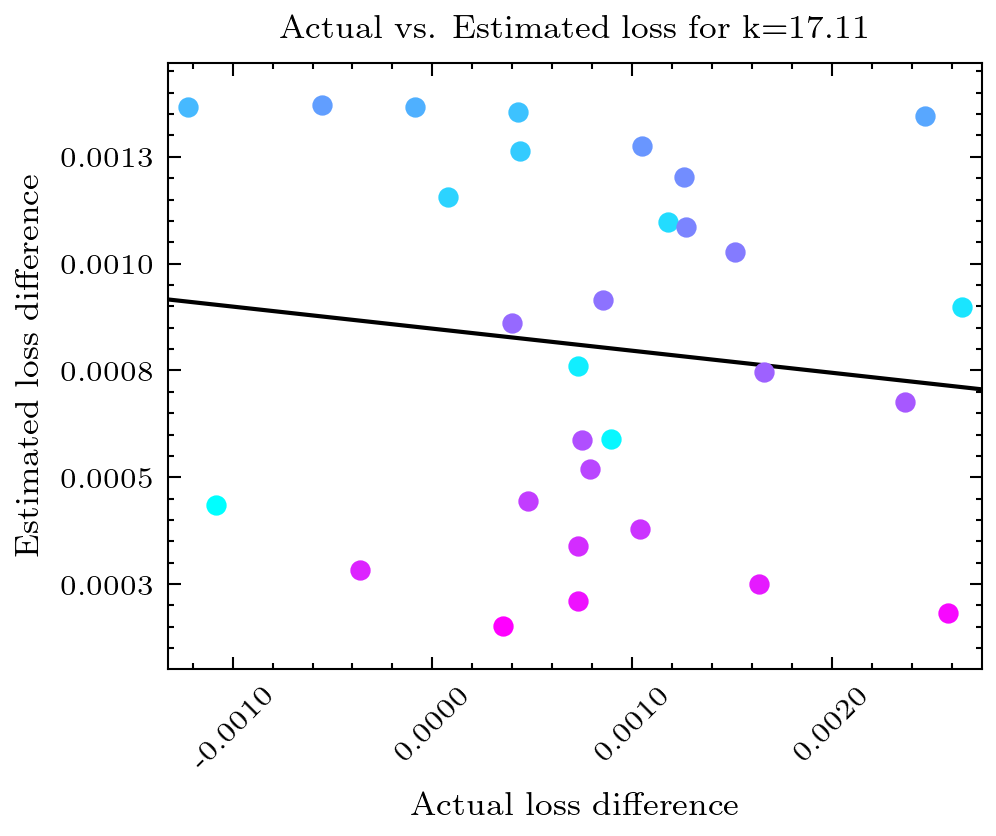


k: 20.333333333333336
ep: 0.001


IHVP sample 2: 100%|█████████████████████████████████████████████████| 7500/7500 [00:10<00:00, 725.02it/s, est norm=5.5]


Approx difference: 0.00051
True difference: 0.00101
ep: 0.17337931034482756
Approx difference: 0.00069
True difference: 0.00257
ep: 0.3457586206896551
Approx difference: 0.00094
True difference: 0.00020
ep: 0.5181379310344827
Approx difference: 0.00111
True difference: 0.00025
ep: 0.6905172413793103
Approx difference: 0.00124
True difference: 0.00240
ep: 0.8628965517241378
Approx difference: 0.00151
True difference: 0.00149
ep: 1.0352758620689653
Approx difference: 0.00157
True difference: 0.00133
ep: 1.207655172413793
Approx difference: 0.00163
True difference: 0.00131
ep: 1.3800344827586204
Approx difference: 0.00174
True difference: 0.00106
ep: 1.5524137931034478
Approx difference: 0.00166
True difference: 0.00087
ep: 1.7247931034482755
Approx difference: 0.00165
True difference: 0.00190
ep: 1.8971724137931032
Approx difference: 0.00160
True difference: 0.00156
ep: 2.0695517241379306
Approx difference: 0.00157
True difference: 0.00021
ep: 2.241931034482758
Approx difference: 0.00148

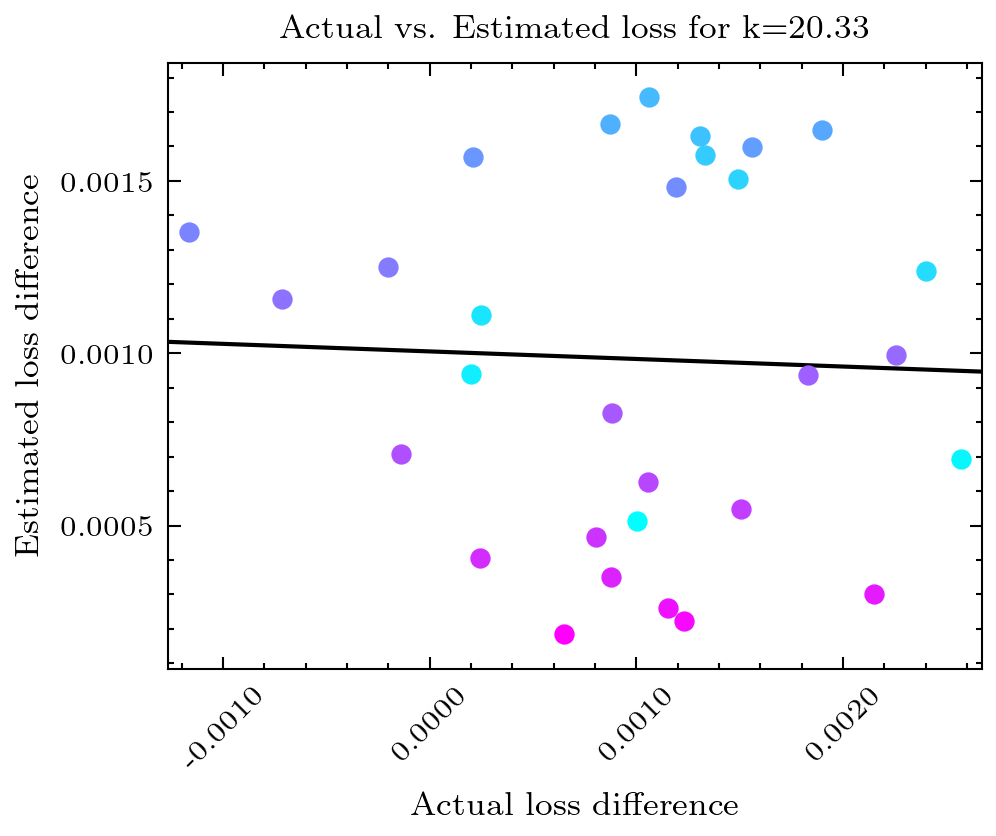


k: 23.555555555555557
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:10<00:00, 729.00it/s, est norm=5.32]


Approx difference: 0.00063
True difference: 0.00131
ep: 0.17337931034482756
Approx difference: 0.00078
True difference: 0.00159
ep: 0.3457586206896551
Approx difference: 0.00103
True difference: 0.00171
ep: 0.5181379310344827
Approx difference: 0.00123
True difference: -0.00127
ep: 0.6905172413793103
Approx difference: 0.00145
True difference: -0.00054
ep: 0.8628965517241378
Approx difference: 0.00159
True difference: 0.00032
ep: 1.0352758620689653
Approx difference: 0.00181
True difference: 0.00131
ep: 1.207655172413793
Approx difference: 0.00190
True difference: 0.00269
ep: 1.3800344827586204
Approx difference: 0.00195
True difference: 0.00076
ep: 1.5524137931034478
Approx difference: 0.00197
True difference: 0.00177
ep: 1.7247931034482755
Approx difference: 0.00192
True difference: 0.00202
ep: 1.8971724137931032
Approx difference: 0.00182
True difference: 0.00118
ep: 2.0695517241379306
Approx difference: 0.00174
True difference: 0.00056
ep: 2.241931034482758
Approx difference: 0.001

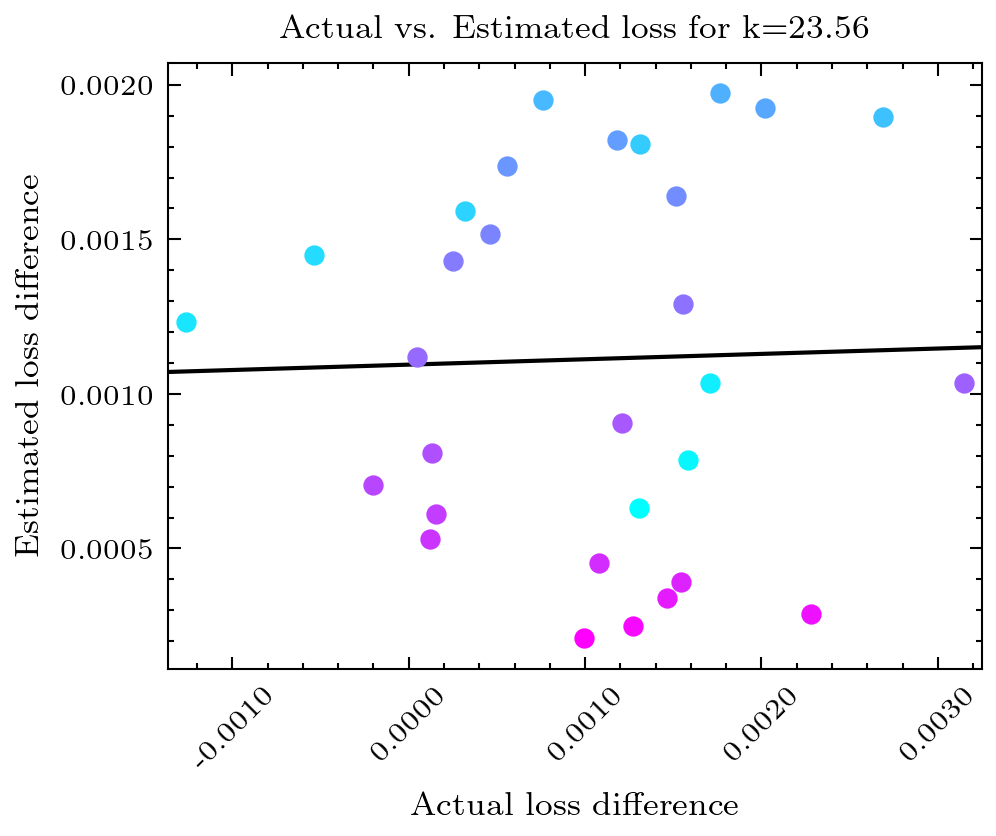


k: 26.77777777777778
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:10<00:00, 736.14it/s, est norm=5.81]


Approx difference: 0.00070
True difference: 0.00025
ep: 0.17337931034482756
Approx difference: 0.00102
True difference: 0.00150
ep: 0.3457586206896551
Approx difference: 0.00135
True difference: -0.00015
ep: 0.5181379310344827
Approx difference: 0.00155
True difference: 0.00051
ep: 0.6905172413793103
Approx difference: 0.00183
True difference: 0.00295
ep: 0.8628965517241378
Approx difference: 0.00202
True difference: 0.00091
ep: 1.0352758620689653
Approx difference: 0.00217
True difference: 0.00060
ep: 1.207655172413793
Approx difference: 0.00234
True difference: 0.00066
ep: 1.3800344827586204
Approx difference: 0.00242
True difference: -0.00003
ep: 1.5524137931034478
Approx difference: 0.00241
True difference: 0.00059
ep: 1.7247931034482755
Approx difference: 0.00230
True difference: 0.00027
ep: 1.8971724137931032
Approx difference: 0.00236
True difference: -0.00025
ep: 2.0695517241379306
Approx difference: 0.00226
True difference: 0.00030
ep: 2.241931034482758
Approx difference: 0.00

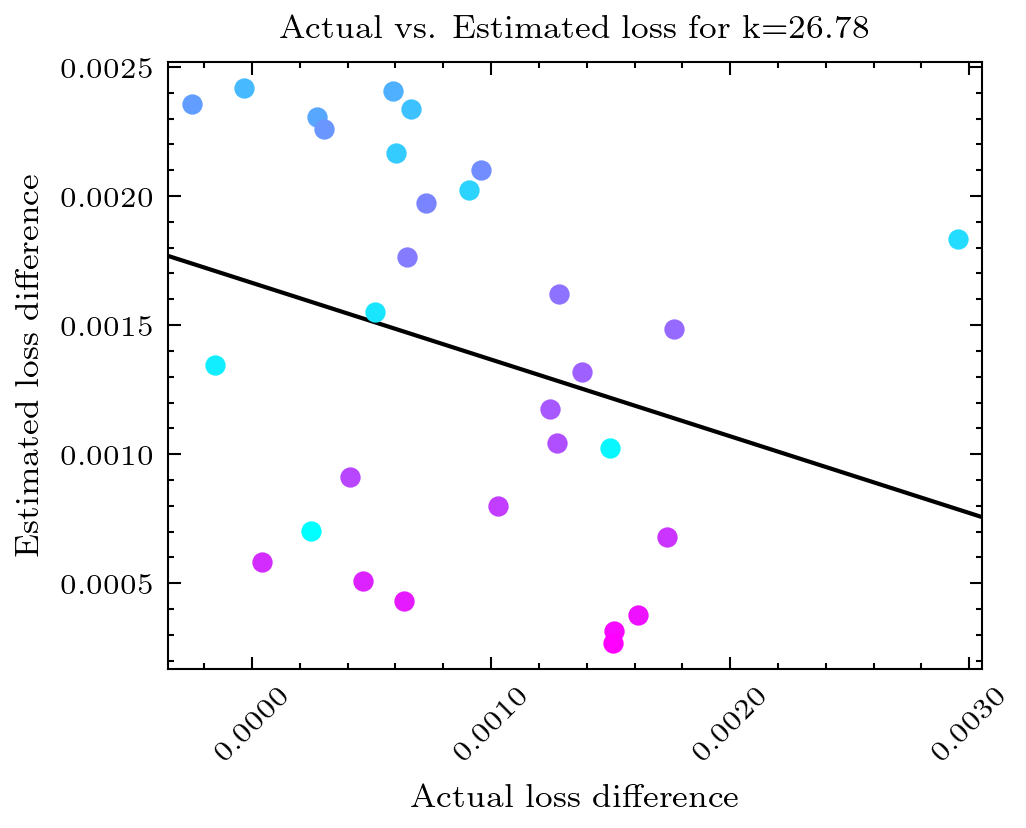


k: 30.0
ep: 0.001


IHVP sample 2: 100%|███████████████████████████████████████████████| 7500/7500 [00:07<00:00, 1003.02it/s, est norm=5.52]


Approx difference: 0.00070
True difference: 0.00079
ep: 0.17337931034482756
Approx difference: 0.00102
True difference: -0.00039
ep: 0.3457586206896551
Approx difference: 0.00136
True difference: -0.00158
ep: 0.5181379310344827
Approx difference: 0.00169
True difference: 0.00033
ep: 0.6905172413793103
Approx difference: 0.00197
True difference: -0.00011
ep: 0.8628965517241378
Approx difference: 0.00221
True difference: 0.00154
ep: 1.0352758620689653
Approx difference: 0.00237
True difference: 0.00133
ep: 1.207655172413793
Approx difference: 0.00248
True difference: 0.00032
ep: 1.3800344827586204
Approx difference: 0.00257
True difference: 0.00110
ep: 1.5524137931034478
Approx difference: 0.00255
True difference: 0.00084
ep: 1.7247931034482755
Approx difference: 0.00251
True difference: 0.00117
ep: 1.8971724137931032
Approx difference: 0.00245
True difference: 0.00104
ep: 2.0695517241379306
Approx difference: 0.00230
True difference: 0.00020
ep: 2.241931034482758
Approx difference: 0.00

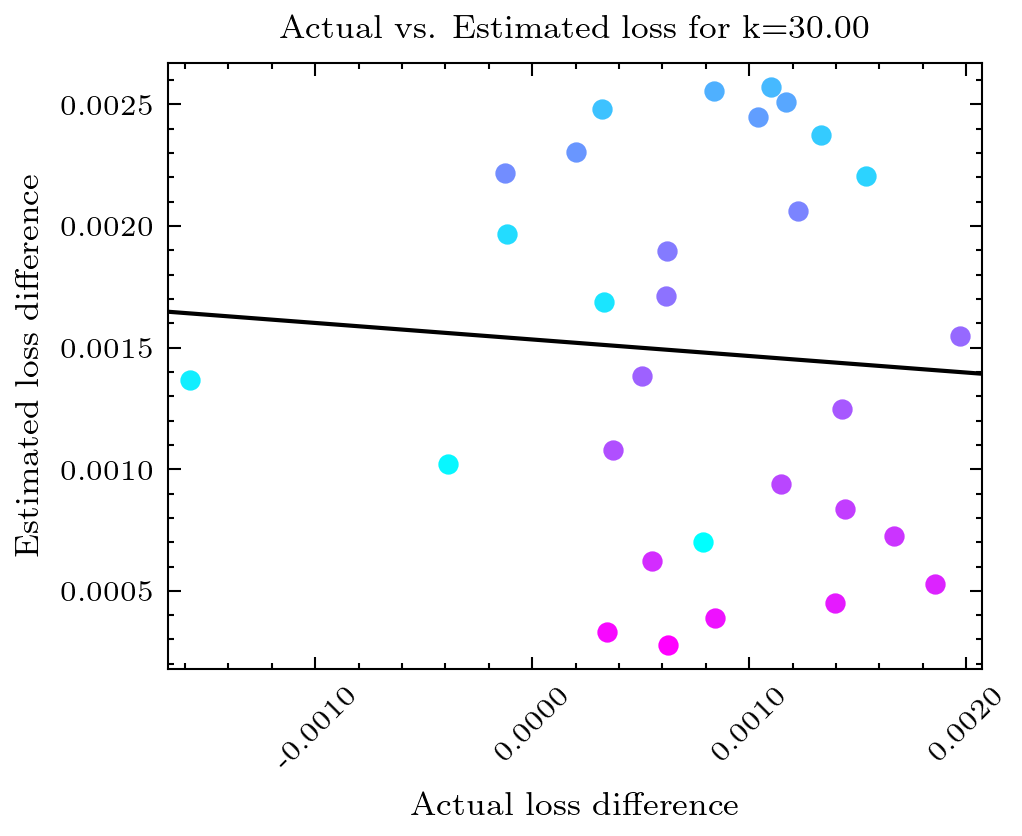

In [23]:
all_orig_loss_e_k, all_est_loss_e_k, all_time = Main('mnist', epsilons, k, rounds)

with open('all_orig_loss_e_k_mnist_flc.txt', "wb") as file:   #Pickling
    pickle.dump(all_orig_loss_e_k, file)

with open('all_est_loss_e_k_mnist_flc.txt', "wb") as file2:   #Pickling
    pickle.dump(all_est_loss_e_k, file2)

In [24]:
with open('all_orig_loss_e_k_mnist_flc.txt', 'rb') as f:
    all_orig_loss_e_k = pickle.load(f)
    
with open('all_est_loss_e_k_mnist_flc.txt', 'rb') as f:
    all_est_loss_e_k = pickle.load(f)

In [25]:
# [actual, estimate]

sum_orig_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_est_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_time = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]

avg_orig_loss = []
avg_est_loss = []
avg_time = []

for round_ in range(len(all_orig_loss_e_k)):
    for e in range(len(epsilons)):
        for k_ in range(len(k)):
            sum_orig_loss_e_k[e][k_] = sum_orig_loss_e_k[e][k_] + all_orig_loss_e_k[round_][e][k_]
            sum_est_loss_e_k[e][k_] = sum_est_loss_e_k[e][k_] + all_est_loss_e_k[round_][e][k_]
            sum_time[e][k_] = sum_time[e][k_] + all_time[round_][e][k_]

for e in range(len(epsilons)):
    avg_orig_loss.append([ elem / len(all_orig_loss_e_k) for elem in sum_orig_loss_e_k[e]])
    avg_est_loss.append([elem/ len(all_orig_loss_e_k) for elem in sum_est_loss_e_k[e]])
    avg_time.append([elem/ len(all_orig_loss_e_k) for elem in sum_time[e]])

k_e_orig = [[] for _ in range(len(k))]
k_e_est = [[] for _ in range(len(k))]

for e in range(len(epsilons)):
    for k_ in range(len(k)):
        k_e_orig[k_].append(avg_orig_loss[e][k_])
        k_e_est[k_].append(avg_est_loss[e][k_])

averaged_time = []

for e in range(len(epsilons)):
    averaged_time.append(sum_time[e][0])

average_time_final = sum(averaged_time) / len(averaged_time)

IndexError: list index out of range

In [ ]:
for i in range(len(k_e_orig)):
    visualize_result(k_e_orig[i], k_e_est[i], epsilons, k[i])